# wps-pipeline-notebook

This is jupyter notebook for the example use of the wps services that are provided by the GFZ in the RIESGOS project.


In [23]:
%load_ext autoreload
%autoreload 2
import owslib.wps as wps
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import numpy as np
import lxml.etree as le
from mpl_toolkits.basemap import Basemap
#
%matplotlib inline

In [2]:
WPS_URL = 'http://rz-vm140.gfz-potsdam.de/wps/WebProcessingService'

In [3]:
server = wps.WebProcessingService(WPS_URL)

So lets see what processes are supported:

In [4]:
server.processes

[<owslib.wps.Process org.n52.wps.server.algorithm.r.AnnotationValidation>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakemapTransformationProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.FlooddamageTiffDownloader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.NrmlCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakemapCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedFlooddamageTiffDownloader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.GeotiffBindingCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedSystemReliabilityProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.SystemReliabilityProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.FlooddamageProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakygroundProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.QuakeledgerProcess>,
 <owslib.wps.Process org

Some of them are test processes, some others are included by default.
We will focus on the following:

| Process | Use case |
|---------|----------|
| Assetmaster | Extraction of the exposure model for a given location |
| Modelprop | Extraction of the vulnerability model with the fragility functions |
| Quakeledger | Earth quake catalog that we use to search for specific events |
| Shakyground | Computation of the pga for a given event |
| Deus | Update of the exposure model with damage states after using the intensities of a given event |

The processes are following a pipeline.

1. Assetmaster
2. Modelprop
3. Quakeledger
4. Shakyground
5. Deus

The order for assetmaster, modelprop and quakeledger can change is not strongly needed. They can be used in any order. However we need to use quakeledger before shakyground and we have to use all other processes before deus (as it needs the exposure model, the fragility functions and the intenstities computed in shakyground).

## Assetmaster
We will start working with the assetmaster dataset.

In [5]:
ID_ASSETMASTER = 'org.n52.gfz.riesgos.algorithm.impl.AssetmasterProcess'

In [6]:
execution_assetmaster = server.execute(
    identifier=ID_ASSETMASTER, 
    inputs=[
        ('lonmin', '-71.8'),
        ('lonmax', '-71.4'),
        ('latmin', '-33.2'),
        ('latmax', '-33.0'),
        ('schema', 'SARA_v1.0'),
        ('assettype', 'res'),
        ('querymode', 'intersects')
    ],
    output=[('selectedRowsGeoJson', True)]
)

wps.monitorExecution(execution_assetmaster)
print('Successful: {}'.format(execution_assetmaster.isSucceded()))

Successful: True


In [7]:
assetmaster_output_reference = execution_assetmaster.processOutputs[0].reference
assetmaster_output = gpd.read_file(assetmaster_output_reference)

In [8]:
assetmaster_output.head()

,gid,name,expo,geometry
0,CHL.16.7.3_1,Quilpue,"{'Repl_cost_USD/bdg': {'1022': 288000.0, '1033...",(POLYGON ((-71.44433593749994 -33.082408905029...
1,CHL.16.7.5_1,Valparaiso,"{'Repl_cost_USD/bdg': {'907': 35000.0, '918': ...",(POLYGON ((-71.68458557128906 -33.102466583251...
2,CHL.16.7.7_1,Vina del Mar,"{'Repl_cost_USD/bdg': {'1091': 288000.0, '1090...",(POLYGON ((-71.55708312988281 -33.014583587646...


### TODO
Add a basemap for the cells.

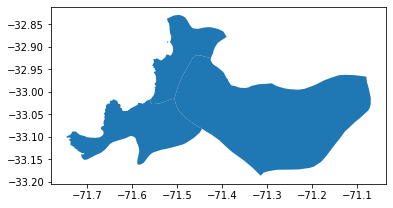

In [9]:
assetmaster_output.plot()

## Modelprop
Next is the modelprop process.

In [10]:
ID_MODELPROP = 'org.n52.gfz.riesgos.algorithm.impl.ModelpropProcess'

In [11]:
execution_modelprop = server.execute(
    identifier=ID_MODELPROP, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('assetcategory', 'buildings'),
        ('losscategory', 'structural'),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_modelprop)
print('Successful: {}'.format(execution_modelprop.isSucceded()))

Successful: True


In [12]:
modelprop_output_reference = execution_modelprop.processOutputs[0].reference
modelprop_output = requests.get(modelprop_output_reference).json()

In [13]:
modelprop_output

{'data': [{'D1_stddev': 0.8,
   'D1_mean': 5.9,
   'D2_stddev': 0.8,
   'D4_mean': 8.2,
   'D4_stddev': 0.8,
   'D3_mean': 7.3,
   'D3_stddev': 0.8,
   'D5_stddev': 0.8,
   'taxonomy': 'URM1',
   'im_min': 1.0,
   'imu': 'g',
   'im_max': 12.0,
   'D2_mean': 6.7,
   'imt': 'pga',
   'D5_mean': 9.2,
   'id': 'unique_id'},
  {'D1_stddev': 0.9,
   'D1_mean': 6.2,
   'D2_stddev': 0.9,
   'D4_mean': 8.7,
   'D4_stddev': 0.9,
   'D3_mean': 7.8,
   'D3_stddev': 0.9,
   'D5_stddev': 0.9,
   'taxonomy': 'URM2',
   'im_min': 1.0,
   'imu': 'g',
   'im_max': 12.0,
   'D2_mean': 7.0,
   'imt': 'pga',
   'D5_mean': 9.8,
   'id': 'unique_id'},
  {'D1_stddev': 1.0,
   'D1_mean': 7.6,
   'D2_stddev': 1.0,
   'D4_mean': 10.5,
   'D4_stddev': 1.0,
   'D3_mean': 9.6,
   'D3_stddev': 1.0,
   'D5_stddev': 1.0,
   'taxonomy': 'CM',
   'im_min': 1.0,
   'imu': 'g',
   'im_max': 12.0,
   'D2_mean': 8.7,
   'imt': 'pga',
   'D5_mean': 11.5,
   'id': 'unique_id'},
  {'D1_stddev': 1.0,
   'D1_mean': 7.6,
   'D2_

In [14]:
urm1_functions = [x for x in modelprop_output['data'] if x['taxonomy'] == 'URM1'][0]

In [15]:
cdf_urm1_d4 = lognorm(scale=np.exp(urm1_functions['D4_mean']), s=urm1_functions['D4_stddev']).cdf

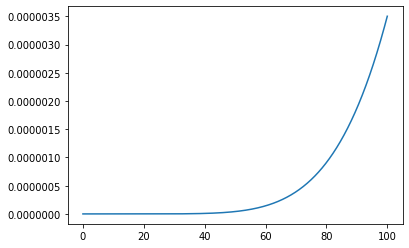

In [16]:
xs = np.linspace(0, 100, 1000)
ys = cdf_urm1_d4(xs)
plt.plot(xs, ys)

## Quakeledger
Now we are interested in the events in our region.

In [17]:
ID_QUAKELEDGER = 'org.n52.gfz.riesgos.algorithm.impl.QuakeledgerProcess'

In [18]:
execution_quakeledger = server.execute(
    identifier=ID_QUAKELEDGER, 
    inputs=[
        ('input-boundingbox', wps.BoundingBoxDataInput([-70, 288 - 360, -10, 292 - 360], 'EPSG:4326')),
        ('mmin', '6.6'),
        ('mmax', '9'),
        ('zmin', '5'),
        ('zmax', '140'),
        ('p', '140'),
        ('etype', 'expert'),
        ('tlon', '-71.5730623712764'),
        ('tlat', '-33.1299174879672'),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_quakeledger)
print('Successful: {}'.format(execution_quakeledger.isSucceded()))

Successful: True


In [19]:
NaNquakeledger_output_reference = execution_quakeledger.processOutputs[0].reference
quakeledger_output = le.fromstring(requests.get(quakeledger_output_reference).content)

In [20]:
quakeledger_output

<Element {http://quakeml.org/xmlns/bed/1.2}eventParameters at 0x7f0f17071888>

In [30]:
import gfzwpsformatconversions

In [31]:
gfzwpsformatconversions.quakeml2df(quakeledger_output).iloc[0]

eventID                            quakeml:quakeledger/CHOA_122
Agency                                                      GFZ
Identifier                                                  NaN
year                                                       2018
month                                                         1
day                                                           1
hour                                                          0
minute                                                        0
second                                                        0
timeUncertainty                                             NaN
longitude                                              -71.2736
longitudeUncertainty                                        NaN
latitude                                               -28.6384
latitudeUncertainty                                         NaN
horizontalUncertainty                                      None
maxHorizontalUncertainty                